# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


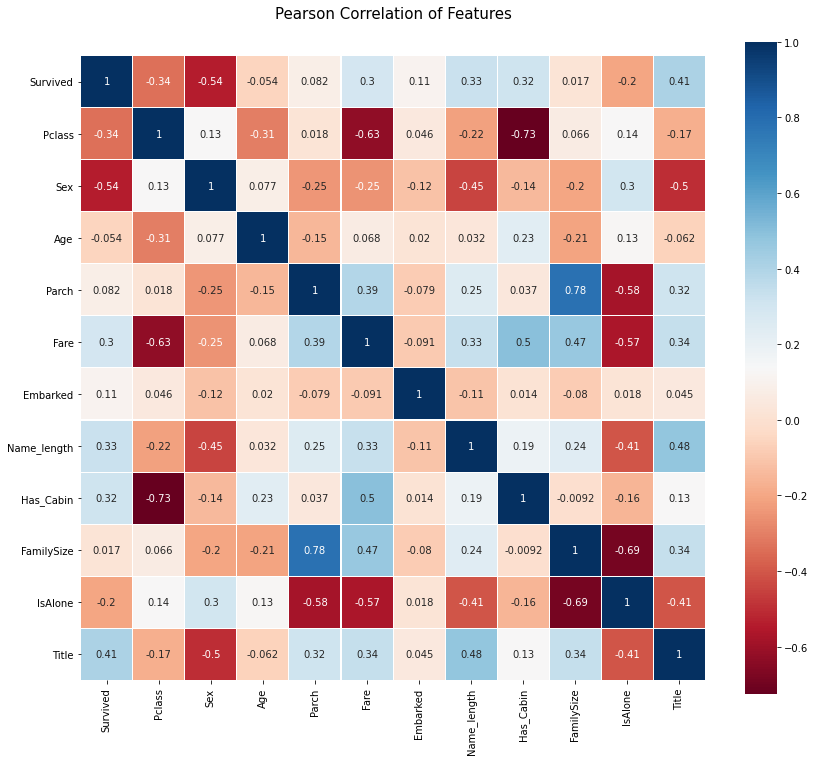

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

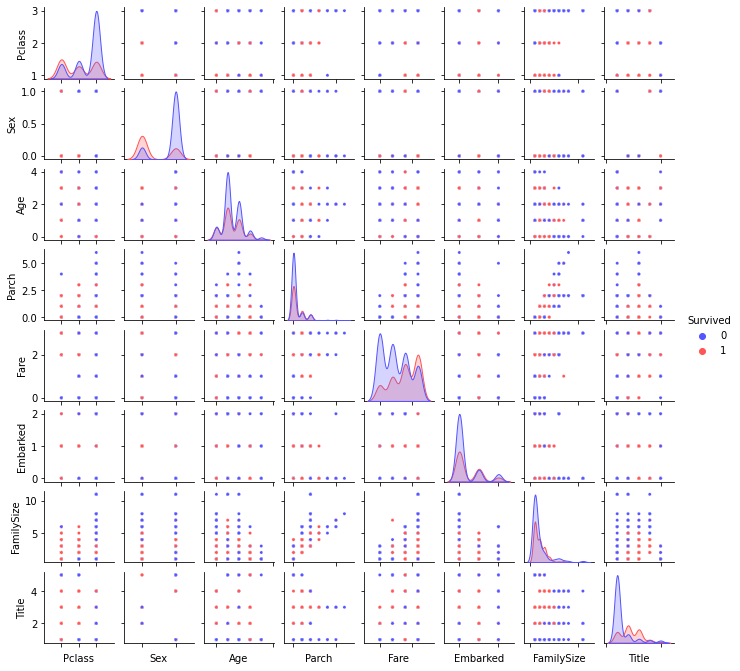

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [9]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)


# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)



X = train.drop(columns=["Survived"])
Y = train["Survived"]

Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.3, random_state=17)

In [23]:
len(X), len(Xt)

(891, 623)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [14]:
# ваш код
gbc_gs = GridSearchCV(gbc, gbc_params, cv=skf)
gbc_gs.fit(Xt, Yt)

rfc_gs = GridSearchCV(rfc, rfc_params, cv=skf)
rfc_gs.fit(Xt, Yt)

svc_gs = GridSearchCV(svc, svc_params, cv=skf)
svc_gs.fit(Xt, Yt)

lr_gs = GridSearchCV(lr, lr_params, cv=skf)
lr_gs.fit(Xt, Yt)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=0.7999999999999999,
                                          class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
gbc = gbc_gs.best_estimator_
rfc = rfc_gs.best_estimator_
svc = svc_gs.best_estimator_
lr = lr_gs.best_estimator_

gbc, rfc, svc, lr

(GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=17, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
  

In [16]:
from sklearn.metrics import accuracy_score

gbc.fit(Xt, Yt)
rfc.fit(Xt, Yt)
svc.fit(Xt, Yt)
lr.fit(Xt, Yt)

print("GBC Accuracy: ", accuracy_score(Yv, gbc.predict(Xv)))
print("RFC Accuracy: ", accuracy_score(Yv, rfc.predict(Xv)))
print("SVC Accuracy: ", accuracy_score(Yv, svc.predict(Xv)))
print("LR  Accuracy: ", accuracy_score(Yv, lr.predict(Xv)))

GBC Accuracy:  0.7649253731343284
RFC Accuracy:  0.7686567164179104
SVC Accuracy:  0.7835820895522388
LR  Accuracy:  0.7947761194029851


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [18]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [21]:
# ваш код
from sklearn.model_selection import cross_val_predict

models = [gbc, rfc, svc, lr]

meta_mtrx = np.empty((Xt.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, Xt, Yt, cv=skf, method='predict')
  
meta_alg = XGBClassifier(random_state=17)
meta_alg_gs = GridSearchCV(meta_alg, xgb_params, cv=skf)
meta_alg_gs.fit(meta_mtrx, Yt)

meta_alg = meta_alg_gs.best_estimator_
meta_alg





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=45, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.30000000000000004, verbosity=1)

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [27]:
len(test)

418

In [28]:
# ваш код
#X_train = X
#Y_train = Y
#X_test = test
#Yv = test["Survival"]

meta_mtrx = np.empty((X.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, X, Y, cv=skf, method='predict')

meta_model = meta_alg.fit(meta_mtrx, Y)
meta_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=45, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.30000000000000004, verbosity=1)

In [29]:
meta_mtrx_test = np.empty((test.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)

meta_predictions = meta_alg.predict(meta_mtrx_test)
len(meta_predictions)

418

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [30]:
def write_to_submission_file(meta_predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)
    predicted_df.head()

In [31]:
# ваш код
write_to_submission_file(meta_predictions, PassengerId)

### 6.
Каков результат score, полученного на соревновании?

0.78708
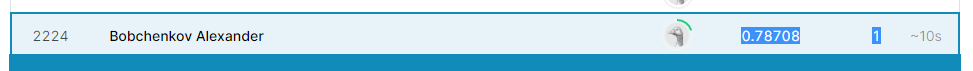